In [2]:
import os, sys
import esutil
import healpy as hp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
def treecorr_xi(lens, random=None, filename=None, rootdir=None, 
		nbins=20, min_sep=2.5, max_sep=250, sep_units='arcmin', bin_slop=0.05, 
        npatch=10, var_method='jackknife', cen_file = None):
    
    import treecorr
    
    if cen_file != None:
        if os.path.exists(cen_file):
            print ('Saved cen_file exists:',cen_file)
            cen_file_switch_on = cen_file
            npatch=1
        else : 
            print ('Create cen_file=',cen_file)
            cen_file_switch_on = None
    
    
    #temp_dir=filename.split('.txt')[0]
    cat_l = treecorr.Catalog(ra=lens['RA'], dec=lens['DEC'], w=lens['WEIGHT'], 
                             ra_units='deg', dec_units='deg', npatch=npatch) #, 
                             #patch_centers=cen_file_switch_on )

    #if cen_file_switch_on == None : 
    #    cat_l.write_patch_centers(cen_file)
       
    cat_r = treecorr.Catalog(ra=random['RA'], dec=random['DEC'], w=random['WEIGHT'], 
                             ra_units='deg', dec_units='deg', patch_centers=cat_l.patch_centers)
                             #patch_centers=cen_file_switch_on )
    
    dd = treecorr.NNCorrelation(nbins=nbins, min_sep=min_sep,
                            max_sep=max_sep, sep_units=sep_units, bin_slop=bin_slop, 
                            var_method=var_method,
                            num_threads=30, verbose=1)
    dr = treecorr.NNCorrelation(nbins=nbins, min_sep=min_sep,
                                max_sep=max_sep, sep_units=sep_units, bin_slop=bin_slop, 
                                var_method=var_method,
                                num_threads=30, verbose=1)
    rd = treecorr.NNCorrelation(nbins=nbins, min_sep=min_sep,
                                max_sep=max_sep, sep_units=sep_units, bin_slop=bin_slop, 
                                var_method=var_method,
                                num_threads=30, verbose=1)
    rr = treecorr.NNCorrelation(nbins=nbins, min_sep=min_sep,
                                max_sep=max_sep, sep_units=sep_units, bin_slop=bin_slop, 
                                var_method=var_method,
                                num_threads=30, verbose=1)

    dd.process(cat_l)
    dr.process(cat_l, cat_r)
    rd.process(cat_r, cat_l)
    rr.process(cat_r)

    #xi,varxi = dd.calculateXi(rr,dr)
    dd.write(filename,rr,dr,rd)
    cov_jk = dd.cov
    
    
    #cov_jk = dd.estimate_cov(var_method)
    #cov_jk_rand = rr.estimate_cov(var_method)
    cov_filename=filename.split('.txt')[0]+'.cov'
    np.savetxt(cov_filename, cov_jk)
    
    print ('save to', filename)


In [4]:
sys.path.append('../code_py3/')
from cmass_modules import io
from utils import appendColumn
#from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
#from xd import mixing_color_elg, assignELGProb, doVisualization_1d, XD_fitting_X
#from run_DMASS_Y3 import priorCut_test
#from systematics import *
sys.path.append('../../DMASS-analysis/measurements/code_py3/')
from ggl_mcal import run_ng_jk, run_nn_jk, run_nk_jk, compute_eix_jk, compute_Rgamma_jk, construct_jk, compute_jkcov, save_results

In [5]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [19]:
# calling the final catalog 
rootdir = '../output/test_cmass_detmodel_mof/'
input_path = rootdir+'test_cat/'
input_keyword = 'Y3_GOLD_2_0_SPT_ra10_20_decm40_m30.fits'
gold_spt_prob = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=None)
pcut = gold_spt_prob['CMASS_PROB'] > 0.01
gold_spt_prob_pcut = gold_spt_prob[ pcut ]


Calling catalogs >>>
DMASS_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30.fits
reading 1/1 ../output/test_cmass_detmodel_mof/test_cat/DMASS_Y3_GOLD_2_0_SPT_ra10_20_decm40_m30.fits


In [20]:
N_dmass = int(np.sum(gold_spt_prob_pcut['CMASS_PROB']))
print (N_dmass)

7625


In [21]:
# calling Y3 GOLD footprint map
# downloaded from https://cdcvs.fnal.gov/redmine/projects/des-y3/wiki/Y3A2_Gold_footprint
mapname='../data/masks/y3a2_footprint_griz_1exp_v2.0.fits.gz'
hpmap_y3gold = hp.read_map(mapname)
goodmask = hp.mask_good(hpmap_y3gold)
hpind_y3gold = np.arange(hpmap_y3gold.size)
goodind = hpind_y3gold[goodmask]
# Generate mask for eboss ELG
#mask_train = np.in1d(elg['HEALIndex'],goodind)

/n/des/lee.5922/programs/anaconda3/envs/env_py3/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [22]:
from utils import uniform_random_on_sphere, spatialcheck

In [23]:
randoms = uniform_random_on_sphere(gold_spt_prob, size = N_dmass*10, z=False )
randoms = randoms[ np.in1d( randoms['HPIX'], goodind) ]

In [24]:
weight_data = gold_spt_prob_pcut['CMASS_PROB']
weight_rand = np.ones(randoms.size)
gold_spt_prob_pcut = appendColumn(gold_spt_prob_pcut, name='WEIGHT', value=weight_data)
randoms = appendColumn(randoms, name='WEIGHT', value=weight_rand)

In [13]:
#cmass_filename = '/n/des/lee.5922/data/cmass_cat/cmass-dr12v4-S-Reid-full.dat.fits'
cmass_filename = '/n/des/lee.5922/data/cmass_cat/galaxy_DR12v5_CMASS_South.fits.gz'
cmass = esutil.io.read(cmass_filename)

filename = '/n/des/lee.5922/data/cmass_cat/random0_DR12v5_CMASS_South.fits.gz'
random_cmass = esutil.io.read(filename)

In [14]:
weight_data = cmass['WEIGHT_FKP']* cmass['WEIGHT_SYSTOT']*(cmass['WEIGHT_CP']+cmass['WEIGHT_NOZ']-1.)
weight_rand = random_cmass['WEIGHT_FKP']
cmass = appendColumn(cmass, name='WEIGHT', value=weight_data)
random_cmass = appendColumn(random_cmass, name='WEIGHT', value=weight_rand)

In [35]:
npatch=100

twoptdir = rootdir+'/2pt/cmass_sgc_jk/'
tempdir = twoptdir+'/{}/'.format(npatch)
#cen_file = tempdir + 'nn_cen_file.txt'
filename = tempdir + 'nn.lens.txt'

os.system('rm -rf '+tempdir)
os.makedirs( tempdir, exist_ok=True )

treecorr_xi(cmass, random=random_cmass,
        filename=filename, rootdir = tempdir, 
        nbins=30, min_sep=0.5, max_sep=250., sep_units='arcmin', bin_slop=0.1,
        npatch=npatch, cen_file=None, var_method='jackknife', )

save to ../output/test_cmass_detmodel_mof//2pt/cmass_sgc_jk//100/nn.lens.txt


In [34]:
npatch=100

twoptdir = rootdir+'/2pt/dmass_jk/'
tempdir = twoptdir+'/{}/'.format(npatch)
#cen_file = tempdir + 'nn_cen_file.txt'
filename = tempdir + 'nn.lens.txt'

os.system('rm -rf '+tempdir)
os.makedirs( tempdir, exist_ok=True )

treecorr_xi(gold_spt_prob_pcut, random=randoms,
        filename=filename, rootdir = tempdir, 
        nbins=30, min_sep=0.5, max_sep=250., sep_units='arcmin', bin_slop=0.1,
        npatch=npatch, cen_file=None, var_method='jackknife', )

save to ../output/test_cmass_detmodel_mof//2pt/dmass_jk//100/nn.lens.txt


In [45]:
tempdir = rootdir+'/2pt/cmass_sgc_jk/'
cov_cmass= np.genfromtxt(tempdir+'/{}/nn.lens.cov'.format(npatch))
err_cmass = np.sqrt(cov_cmass.diagonal())
_, meanr_cmass, _, galaxy_xi_cmass, xi_err,_,_,_,_,_ = \
np.genfromtxt(tempdir+'/{}/nn.lens.txt'.format(npatch), unpack=True)

In [46]:
tempdir = rootdir+'/2pt/dmass_jk/'
cov_dmass= np.genfromtxt(tempdir+'/{}/nn.lens.cov'.format(npatch))
err_dmass = np.sqrt(cov_dmass.diagonal())
_, meanr_dmass, _, galaxy_xi_dmass, xi_err,_,_,_,_,_ = \
np.genfromtxt(tempdir+'/{}/nn.lens.txt'.format(npatch), unpack=True)

In [38]:
# new one

(1.2, 322.4198766787144)

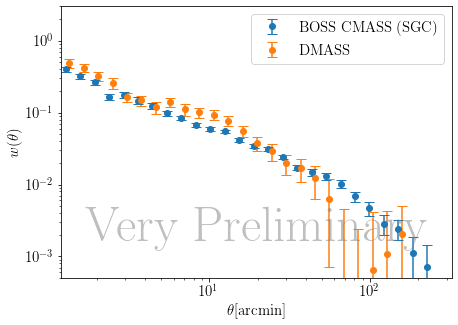

In [41]:
fig, ax = plt.subplots(figsize=(7,5))
ax.errorbar(meanr_cmass, galaxy_xi_cmass, yerr=err_cmass, fmt='o', capsize=5, label='${\\rm BOSS ~CMASS~(SGC)}$')
ax.errorbar(meanr_dmass*1.05, galaxy_xi_dmass, yerr=err_dmass, fmt='o',capsize=5, label='${\\rm DMASS}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=15)
ax.set_xlabel('$\\theta {\\rm[arcmin]}$', fontsize=15)
ax.set_ylabel('$w(\\theta)$',fontsize=15)

ax.tick_params(labelsize=15)

ax.text(0.5, 0.1, '${\\rm Very~Preliminary}$', transform=ax.transAxes,
        fontsize=50, color='gray', alpha=0.5,
        ha='center', va='bottom', rotation='0')
ax.set_ylim(5e-04,)
ax.set_xlim(1.2,)

(2.5, 322.4198766787144)

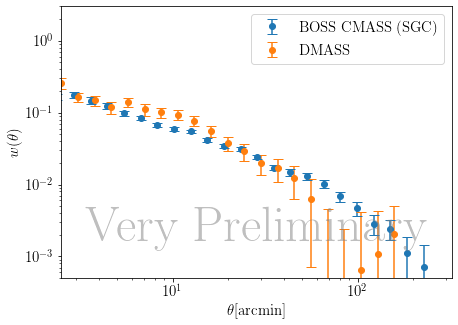

In [43]:
fig, ax = plt.subplots(figsize=(7,5))
ax.errorbar(meanr_cmass, galaxy_xi_cmass, yerr=err_cmass, fmt='o', capsize=5, label='${\\rm BOSS ~CMASS~(SGC)}$')
ax.errorbar(meanr_dmass*1.05, galaxy_xi_dmass, yerr=err_dmass, fmt='o',capsize=5, label='${\\rm DMASS}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=15)
ax.set_xlabel('$\\theta {\\rm[arcmin]}$', fontsize=15)
ax.set_ylabel('$w(\\theta)$',fontsize=15)

ax.tick_params(labelsize=15)

ax.text(0.5, 0.1, '${\\rm Very~Preliminary}$', transform=ax.transAxes,
        fontsize=50, color='gray', alpha=0.5,
        ha='center', va='bottom', rotation='0')
ax.set_ylim(5e-04,)
ax.set_xlim(2.5,)

(0.0005, 0.3448861578740674)

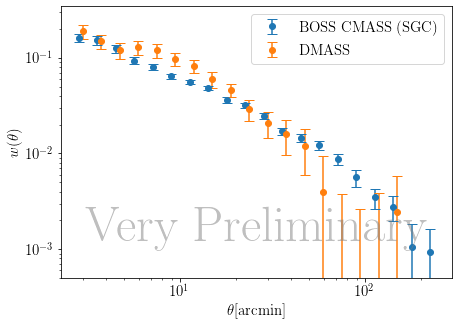

In [33]:
fig, ax = plt.subplots(figsize=(7,5))
ax.errorbar(meanr_cmass, galaxy_xi_cmass, yerr=err_cmass, fmt='o', capsize=5, label='${\\rm BOSS ~CMASS~(SGC)}$')
ax.errorbar(meanr_dmass*1.05, galaxy_xi_dmass, yerr=err_dmass, fmt='o',capsize=5, label='${\\rm DMASS}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=15)
ax.set_xlabel('$\\theta {\\rm[arcmin]}$', fontsize=15)
ax.set_ylabel('$w(\\theta)$',fontsize=15)

ax.tick_params(labelsize=15)

ax.text(0.5, 0.1, '${\\rm Very~Preliminary}$', transform=ax.transAxes,
        fontsize=50, color='gray', alpha=0.5,
        ha='center', va='bottom', rotation='0')
ax.set_ylim(5e-04,)

Text(0.5, 0.1, '${\\rm Very~Preliminary}$')

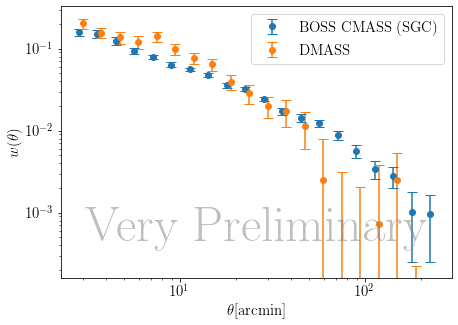

In [47]:
fig, ax = plt.subplots(figsize=(7,5))
ax.errorbar(meanr_cmass, galaxy_xi_cmass, yerr=err_cmass, fmt='o', capsize=5, label='${\\rm BOSS ~CMASS~(SGC)}$')
ax.errorbar(meanr_dmass*1.05, galaxy_xi_dmass, yerr=err_dmass, fmt='o',capsize=5, label='${\\rm DMASS}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=15)
ax.set_xlabel('$\\theta {\\rm[arcmin]}$', fontsize=15)
ax.set_ylabel('$w(\\theta)$',fontsize=15)

ax.tick_params(labelsize=15)

ax.text(0.5, 0.1, '${\\rm Very~Preliminary}$', transform=ax.transAxes,
        fontsize=50, color='gray', alpha=0.5,
        ha='center', va='bottom', rotation='0')